NOAA download data: Extract period of record for each station and variables of interest (water levels, flow) 
This option allows you to use two or more stations.
Differents plots.

In [1]:
#Libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt

Data fetched successfully for station 8594900:
            date_time  water_level      s        f  q
0 2021-08-29 00:00:00        0.119  0.005  0,0,0,0  v
1 2021-08-29 00:06:00        0.123  0.005  0,0,0,0  v
2 2021-08-29 00:12:00        0.129  0.003  0,0,0,0  v
3 2021-08-29 00:18:00        0.137  0.002  0,0,0,0  v
4 2021-08-29 00:24:00        0.145  0.005  0,0,0,0  v
Data saved to noaa_water_levels_8594900_20210829_20210901.csv
Hydrograph saved as hydrograph_8594900_20210829_20210901.png


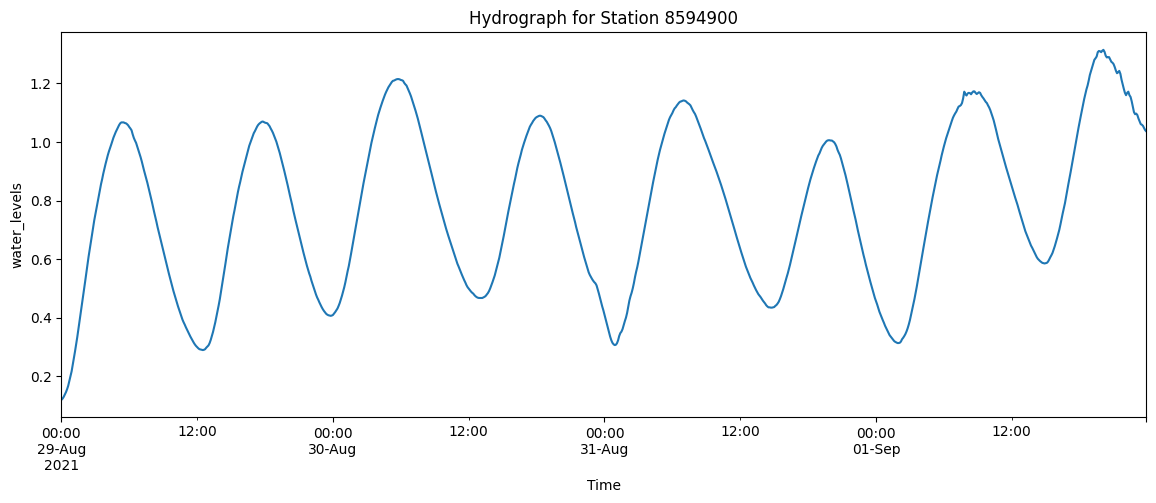

Data fetched successfully for station 8635750:
            date_time  water_level      s        f  q
0 2021-08-29 00:00:00        0.646  0.006  0,0,0,0  v
1 2021-08-29 00:06:00        0.642  0.005  0,0,0,0  v
2 2021-08-29 00:12:00        0.639  0.004  0,0,0,0  v
3 2021-08-29 00:18:00        0.636  0.005  0,0,0,0  v
4 2021-08-29 00:24:00        0.630  0.002  0,0,0,0  v
Data saved to noaa_water_levels_8635750_20210829_20210901.csv
Hydrograph saved as hydrograph_8635750_20210829_20210901.png


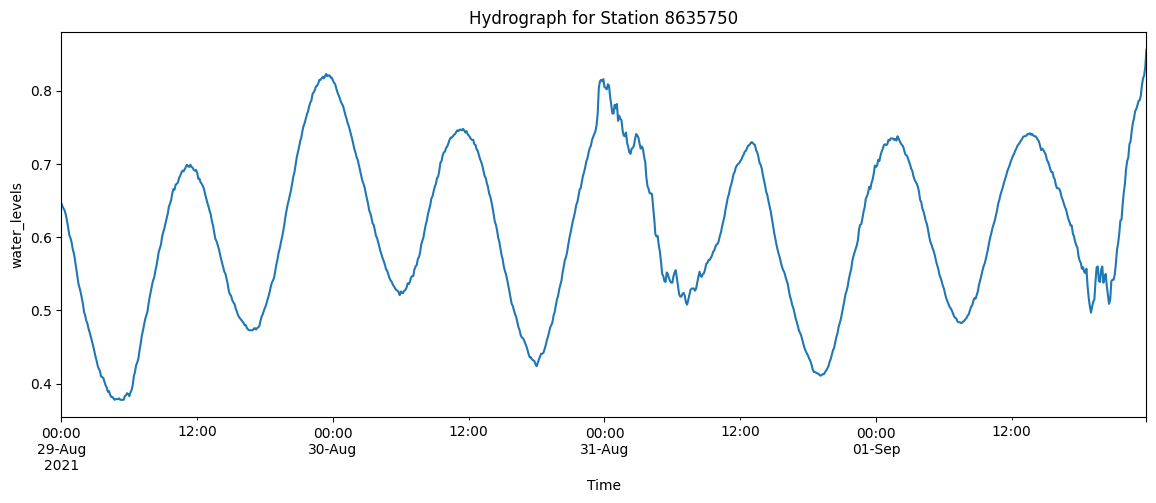

In [5]:
#

def get_water_levels(start_date, end_date, station_id, datum='MLLW', units='metric', time_zone='gmt', product='water_level', format='json'):
    """
    Fetch water levels from NOAA Tides and Currents API.

    Parameters:
    start_date (str): Start date in YYYYMMDD format.
    end_date (str): End date in YYYYMMDD format.
    station_id (str): NOAA station ID.
    datum (str): Datum to use for water level data. Default is 'MLLW'.
    units (str): Units of measurement. Default is 'metric'.
    time_zone (str): Time zone. Default is 'gmt'.
    product (str): Data product to retrieve. Default is 'water_level'.
    format (str): Response format. Default is 'json'.

    Returns:
    pd.DataFrame: DataFrame containing date and water level data.
    """
    base_url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
    params = {
        'begin_date': start_date,
        'end_date': end_date,
        'station': station_id,
        'product': product,
        'datum': datum,
        'units': units,
        'time_zone': time_zone,
        'format': format
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code}, Details: {response.text}")
    
    data = response.json()
    
    if 'error' in data:
        raise Exception(f"Error in response: {data['error']['message']}")
    
    # Convert data to DataFrame
    df = pd.DataFrame(data['data'])
    df['t'] = pd.to_datetime(df['t'])  # Ensure that 't' includes both date and time
    df.rename(columns={'t': 'date_time', 'v': 'water_level'}, inplace=True)
    
    # Ensure water_level is numeric and handle errors
    df['water_level'] = pd.to_numeric(df['water_level'], errors='coerce')
    
    # Drop rows with missing or non-numeric water levels
    df = df.dropna(subset=['water_level'])
    
    return df

def plot_hydrograph(water_levels, station_id, start_date, end_date):
    """
    Plot a hydrograph using the water level data.

    Parameters:
    water_levels (pd.DataFrame): DataFrame containing the water level data.
    station_id (str): NOAA station ID.
    start_date (str): Start date in YYYYMMDD format.
    end_date (str): End date in YYYYMMDD format.
    """
    # Plot using pandas' built-in plotting function
    water_levels.plot(x='date_time', y='water_level', figsize=(14, 5), title=f'Hydrograph for Station {station_id}', xlabel='Time', ylabel='water_levels', legend=False)
    
    # Save the plot as a PNG image
    plot_file_name = f'hydrograph_{station_id}_{start_date}_{end_date}.png'
    plt.savefig(plot_file_name)
    print(f"Hydrograph saved as {plot_file_name}")
    
    # Show the plot
    plt.show()

def main():
    # User inputs
    start_date = input("Enter start date (YYYYMMDD): ")
    end_date = input("Enter end date (YYYYMMDD): ")
    
    # Input for multiple station IDs, separated by commas
    station_ids = input("Enter NOAA station IDs separated by commas: ").split(',')

    # Validate input formats
    if not (len(start_date) == 8 and start_date.isdigit()):
        print("Invalid start date format. Please use YYYYMMDD.")
        return
    if not (len(end_date) == 8 and end_date.isdigit()):
        print("Invalid end date format. Please use YYYYMMDD.")
        return

    for station_id in station_ids:
        station_id = station_id.strip()  # Clean up whitespace
        if not station_id.isdigit():
            print(f"Invalid station ID: {station_id}. Please use a valid numeric station ID.")
            continue
        
        # Fetch water levels for the current station ID
        try:
            water_levels = get_water_levels(start_date, end_date, station_id)
            print(f"Data fetched successfully for station {station_id}:")
            print(water_levels.head())
            
            # Save data to CSV
            file_name = f'noaa_water_levels_{station_id}_{start_date}_{end_date}.csv'
            water_levels.to_csv(file_name, index=False)
            print(f"Data saved to {file_name}")
            
            # Plot hydrograph for the current station ID
            plot_hydrograph(water_levels, station_id, start_date, end_date)
            
        except Exception as e:
            print(f"Error processing station {station_id}: {e}")

if __name__ == "__main__":
    main()
